# Capstone Notebook 2

## Casey Nosiglia

In this notebook, we will want to classify particular diseases among the `Tomato` species, which includes 10 different classes (1 healthy + 9 diseased). We will use the framework for creating a directory developed in the first notebook through the use of the dataframe `full_dataframe`, and then we will construct CNN models in order to try and learn the classifications.

## Load in relevant libraries (may need more later, but this should be sufficient for now):

In [1]:
# load in all of the relevant libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# image handling and path libraries
import os
import PIL
import pathlib
from PIL import Image 
import glob
import shutil

In [3]:
# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
# tensorflow libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

## Data manipulation

In this section, we will create the image directory for the `Tomato` species, including a train/validation/test split.

In [5]:
# load in the full_dataframe to make more directory structures for CNN modelling:
full_dataframe = pd.read_csv('full_dataframe.csv')
full_dataframe.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

full_dataframe.head()

,ID,is_diseased,Species,Disease_Type
0,dataset/train/Apple___Apple_scab/14c623e5-051c...,1,Apple,Apple_scab
1,dataset/train/Apple___Apple_scab/bceb695a-e877...,1,Apple,Apple_scab
2,dataset/train/Apple___Apple_scab/623fb084-dbac...,1,Apple,Apple_scab
3,dataset/train/Apple___Apple_scab/be517ff5-5e63...,1,Apple,Apple_scab
4,dataset/train/Apple___Apple_scab/88079400-60e9...,1,Apple,Apple_scab


We want to only look at the class distribution for the `Tomato` species:

Tomato classes Distribution:

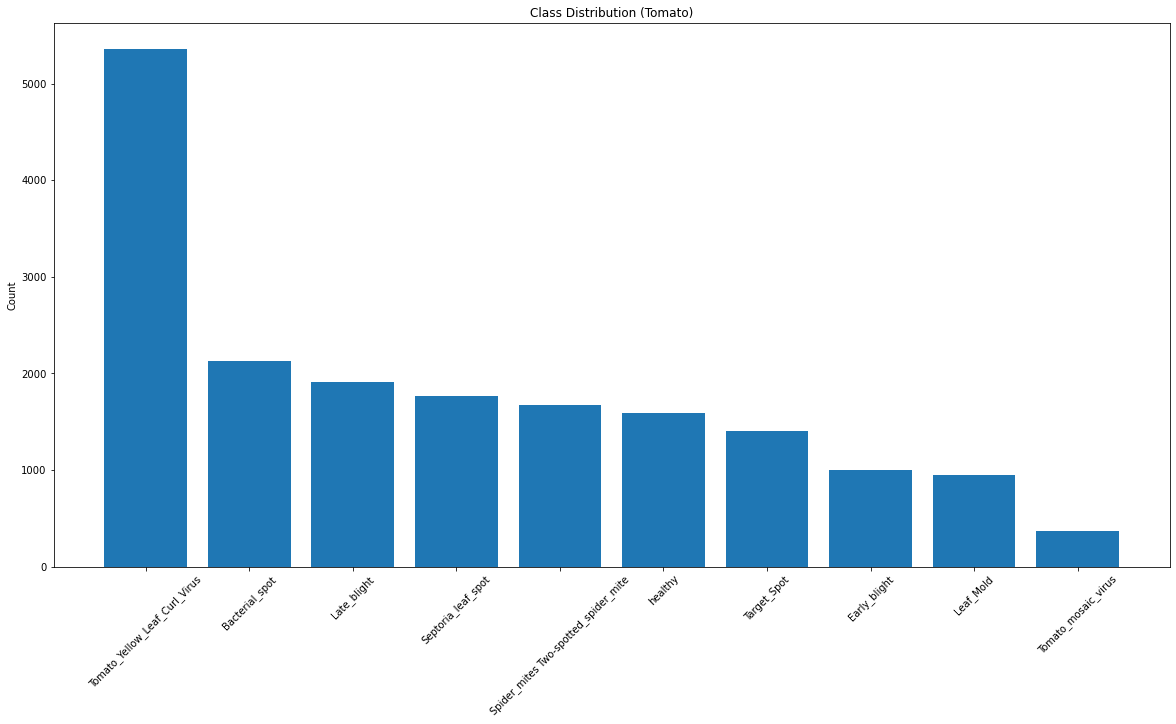

In [6]:
plt.figure(figsize = (20,10))
plt.bar(full_dataframe[full_dataframe['Species']=='Tomato']['Disease_Type'].value_counts().index,full_dataframe[full_dataframe['Species']=='Tomato']['Disease_Type'].value_counts())
plt.xticks(rotation = 45)
plt.ylabel("Count")
plt.title("Class Distribution (Tomato)")
plt.show()

We see that the class distribution for the `Tomato` species is highly imblanced, so we want to make an evenly distributed sample by upsampling and downsampling. Let's look at the numbers:

In [7]:
# distribution of the tomato diseases:
full_dataframe[full_dataframe['Species'] == 'Tomato']['Disease_Type'].value_counts()

Tomato_Yellow_Leaf_Curl_Virus           5357
Bacterial_spot                          2127
Late_blight                             1909
Septoria_leaf_spot                      1771
Spider_mites Two-spotted_spider_mite    1676
healthy                                 1591
Target_Spot                             1404
Early_blight                            1000
Leaf_Mold                                952
Tomato_mosaic_virus                      373
Name: Disease_Type, dtype: int64

Based on the above numbers, we want to resample to 1000 in each category for hte `Tomato` species:

In [8]:
# get the indices for the various tomato diseases:
spec_dis_list = full_dataframe[full_dataframe['Species'] == 'Tomato']\
                ['Disease_Type'].value_counts().index.to_list()

In [9]:
resampled_tomato = pd.DataFrame(columns = ['ID', 'is_diseased', 'Species','Disease_Type'])

#resampling loop (including randomized downsampling and upsampling):
for i in range(0,len(spec_dis_list)):
    # downsampling
    if full_dataframe.loc[(full_dataframe['Species'] == 'Tomato') & 
       (full_dataframe['Disease_Type'] == spec_dis_list[i])].shape[0] > 1000:
        
        resampled_tomato = pd.concat([resampled_tomato,
                           full_dataframe.loc[(full_dataframe['Species'] == 'Tomato') &
                          (full_dataframe['Disease_Type'] == spec_dis_list[i])].sample(1000)],axis = 0)
    # upsampling    
    else: 
        resampled_tomato = pd.concat([resampled_tomato,
                    full_dataframe.loc[(full_dataframe['Species'] == 'Tomato') &
                    (full_dataframe['Disease_Type'] == spec_dis_list[i])].sample(1000, replace = True)],axis = 0)

In [10]:
resampled_tomato.head()

,ID,is_diseased,Species,Disease_Type
41649,dataset/train/Tomato___Tomato_Yellow_Leaf_Curl...,1,Tomato,Tomato_Yellow_Leaf_Curl_Virus
42737,dataset/train/Tomato___Tomato_Yellow_Leaf_Curl...,1,Tomato,Tomato_Yellow_Leaf_Curl_Virus
39539,dataset/train/Tomato___Tomato_Yellow_Leaf_Curl...,1,Tomato,Tomato_Yellow_Leaf_Curl_Virus
40686,dataset/train/Tomato___Tomato_Yellow_Leaf_Curl...,1,Tomato,Tomato_Yellow_Leaf_Curl_Virus
40390,dataset/train/Tomato___Tomato_Yellow_Leaf_Curl...,1,Tomato,Tomato_Yellow_Leaf_Curl_Virus


In [11]:
resampled_tomato.shape

(10000, 4)

In [12]:
# reindex:
resampled_tomato.reset_index(drop=True, inplace=True)
resampled_tomato.head()

,ID,is_diseased,Species,Disease_Type
0,dataset/train/Tomato___Tomato_Yellow_Leaf_Curl...,1,Tomato,Tomato_Yellow_Leaf_Curl_Virus
1,dataset/train/Tomato___Tomato_Yellow_Leaf_Curl...,1,Tomato,Tomato_Yellow_Leaf_Curl_Virus
2,dataset/train/Tomato___Tomato_Yellow_Leaf_Curl...,1,Tomato,Tomato_Yellow_Leaf_Curl_Virus
3,dataset/train/Tomato___Tomato_Yellow_Leaf_Curl...,1,Tomato,Tomato_Yellow_Leaf_Curl_Virus
4,dataset/train/Tomato___Tomato_Yellow_Leaf_Curl...,1,Tomato,Tomato_Yellow_Leaf_Curl_Virus


In [13]:
resampled_tomato['Disease_Type'].value_counts()

Tomato_Yellow_Leaf_Curl_Virus           1000
Bacterial_spot                          1000
Late_blight                             1000
Septoria_leaf_spot                      1000
Spider_mites Two-spotted_spider_mite    1000
healthy                                 1000
Target_Spot                             1000
Early_blight                            1000
Leaf_Mold                               1000
Tomato_mosaic_virus                     1000
Name: Disease_Type, dtype: int64

We can make a plot of the Tomato class distribution after resampling:

In [14]:
plt.rcParams.update({'font.size': 12})

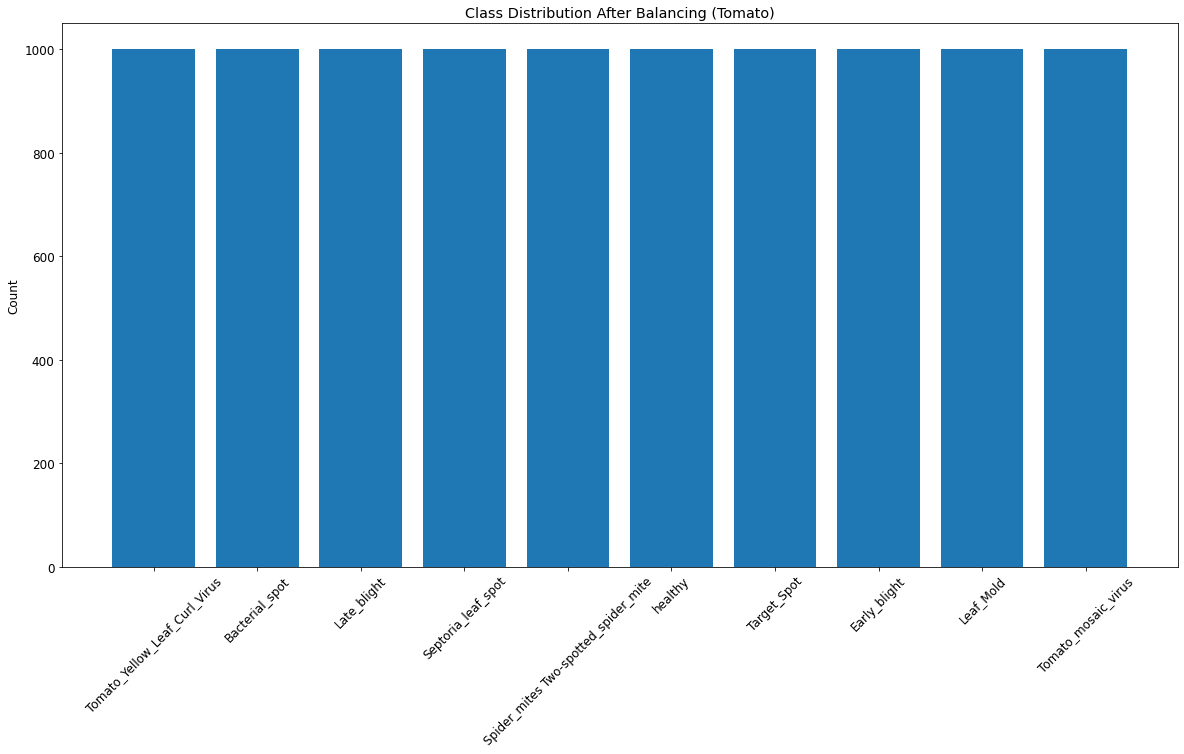

In [15]:
plt.figure(figsize = (20,10))
plt.bar(resampled_tomato[resampled_tomato['Species']=='Tomato']['Disease_Type'].value_counts().index,resampled_tomato[resampled_tomato['Species']=='Tomato']['Disease_Type'].value_counts())
plt.xticks(rotation = 45)
plt.ylabel("Count")
plt.title("Class Distribution After Balancing (Tomato)")
plt.show()

Now we want to create another directory of only the `Tomato` species using the `resampled_tomato` dataframe, with a train/validation/test structure:

In [16]:
# make a list of the desired file paths:
folders = ['Tomato___'+spec_dis_list[i] for i\
              in range(0,len(spec_dis_list))]

# make empty directory structure:
! mkdir resampled_tomato
! mkdir resampled_tomato/test
! mkdir resampled_tomato/train
! mkdir resampled_tomato/validation
for folder in folders:
    os.mkdir(os.path.join('resampled_tomato/test/',folder))
    os.mkdir(os.path.join('resampled_tomato/train/',folder))
    os.mkdir(os.path.join('resampled_tomato/validation/',folder))

In [17]:
# create the folders column and concatenate to the resampled_tomato df 
# for ease of manipulation:
folders_col = pd.DataFrame({'Folders': 
              ['Tomato___'+ resampled_tomato['Disease_Type'][i] 
               for i in range(0,resampled_tomato['Disease_Type'].shape[0])]})

In [18]:
resampled_tomato = pd.concat([resampled_tomato, folders_col], axis = 1)

Now we want to fill the directory. We will need to make the train/validation/test split to iterate through:

In [19]:
# 80/20 train/test split:
train_tomato, test_tomato = train_test_split(resampled_tomato,
                                             test_size = 0.2,
                                             stratify = resampled_tomato['Folders'])

In [20]:
# 70/30 train/validation split:
train_r_tomato, val_tomato = train_test_split(train_tomato,
                                              test_size = 0.3,
                                              stratify = train_tomato['Folders'])

In [21]:
train_r_tomato['Folders'].value_counts()

Tomato___Septoria_leaf_spot                      560
Tomato___Bacterial_spot                          560
Tomato___Target_Spot                             560
Tomato___Leaf_Mold                               560
Tomato___healthy                                 560
Tomato___Early_blight                            560
Tomato___Tomato_Yellow_Leaf_Curl_Virus           560
Tomato___Spider_mites Two-spotted_spider_mite    560
Tomato___Tomato_mosaic_virus                     560
Tomato___Late_blight                             560
Name: Folders, dtype: int64

In [22]:
val_tomato['Folders'].value_counts()

Tomato___Late_blight                             240
Tomato___Spider_mites Two-spotted_spider_mite    240
Tomato___Septoria_leaf_spot                      240
Tomato___Leaf_Mold                               240
Tomato___Tomato_mosaic_virus                     240
Tomato___Tomato_Yellow_Leaf_Curl_Virus           240
Tomato___Target_Spot                             240
Tomato___healthy                                 240
Tomato___Early_blight                            240
Tomato___Bacterial_spot                          240
Name: Folders, dtype: int64

In [23]:
test_tomato['Folders'].value_counts()

Tomato___Leaf_Mold                               200
Tomato___Tomato_mosaic_virus                     200
Tomato___Bacterial_spot                          200
Tomato___healthy                                 200
Tomato___Septoria_leaf_spot                      200
Tomato___Target_Spot                             200
Tomato___Tomato_Yellow_Leaf_Curl_Virus           200
Tomato___Late_blight                             200
Tomato___Early_blight                            200
Tomato___Spider_mites Two-spotted_spider_mite    200
Name: Folders, dtype: int64

Now that we have the train/validation/test split, we want to fill up the tomato directory. Since we did upsampling and therefore will have some duplicates, we need the safe_copy function:

In [24]:
'''safe_copy function, which allows copying the same file path from a given directory
   multiple times, by assigning a new file extension to the repeat copied file.'''
# function taken from:
# https://stackoverflow.com/questions/33282647/python-shutil-copy-if-i-have-a-duplicate-file-will-it-copy-to-new-location

def safe_copy(file_path, out_dir, dst = None):
    """Safely copy a file to the specified directory. If a file with the same name already 
    exists, the copied file name is altered to preserve both.

    :param str file_path: Path to the file to copy.
    :param str out_dir: Directory to copy the file into.
    :param str dst: New name for the copied file. If None, use the name of the original
        file.
    """
    name = dst or os.path.basename(file_path)
    if not os.path.exists(os.path.join(out_dir, name)):
        shutil.copy(file_path, os.path.join(out_dir, name))
    else:
        base, extension = os.path.splitext(name)
        i = 1
        while os.path.exists(os.path.join(out_dir, '{}_{}{}'.format(base, i, extension))):
            i += 1
        shutil.copy(file_path, os.path.join(out_dir, '{}_{}{}'.format(base, i, extension)))

Now to fill up the `tomato` directory:

In [25]:
train_IDs = train_r_tomato['ID'].to_list()
test_IDs = test_tomato['ID'].to_list()
val_IDs = val_tomato['ID'].to_list()

for ID in train_IDs:
    for folder in folders:
        if folder in ID:
            safe_copy(ID, 'resampled_tomato/train/' + folder)
            
for ID in test_IDs:
    for folder in folders:
        if folder in ID:
            safe_copy(ID, 'resampled_tomato/test/' + folder)

for ID in val_IDs:
    for folder in folders:
        if folder in ID:
            safe_copy(ID, 'resampled_tomato/validation/' + folder)

Now we have the directory `resampled_tomato` filled. Now we can load in the data using hte `ImageDataGenerator` functionality of Keras in order to generate the train, validation, and test sets:

In [26]:
# Specify the dimensions we want our images to be preprocessed to
# (This will allow us to images of different resolutions)
height = 256
width = 256
channels = 3

# Create training image data generator.
# We introduce data augmentation to the train set
# in order to reduce overfitting.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create test image data generator.
# Only apply rescaling to our validation data.
test_datagen = ImageDataGenerator(rescale=1./255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('resampled_tomato/train',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory('resampled_tomato/validation',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

# set the batch size to the number of images in the test directory:
test_generator=test_datagen.flow_from_directory('resampled_tomato/test',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=2000,
                                                 class_mode='categorical')

X_test, y_test = test_generator.next()

Found 5600 images belonging to 10 classes.
Found 2400 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


Let's look at a sample of the various classes for the `Tomato` species:

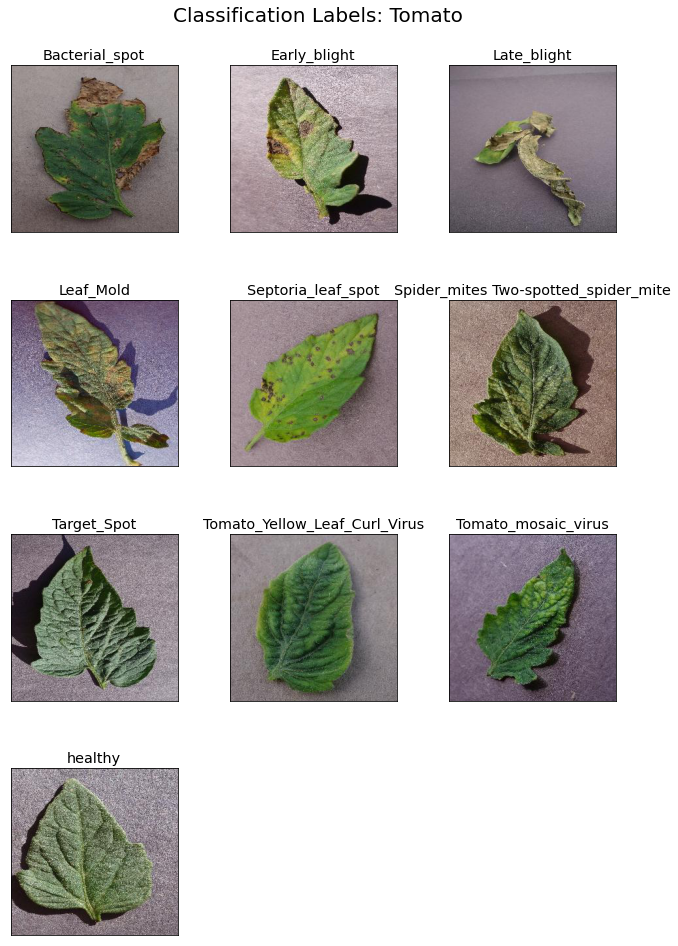

In [27]:
# Grab a batch of images from our validation generator: 
x, y = validation_generator.next() 

# Our images labels are one-hot encoded, lets 
# convert them to ordinal encoding
labels = np.argmax(y, axis=1)

label_names =  ['Tomato___Bacterial_spot',
                'Tomato___Early_blight',
                'Tomato___Late_blight',
                'Tomato___Leaf_Mold',
                'Tomato___Septoria_leaf_spot',
                'Tomato___Spider_mites Two-spotted_spider_mite',
                'Tomato___Target_Spot',
                'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
                'Tomato___Tomato_mosaic_virus',
                'Tomato___healthy']

disease_names = [label_names[i].split("___")[1] for i in range(len(label_names))]

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(9, 14))
ax = ax.flatten()

for i in range(10):
    index = np.argmax(labels==i) 
    ax[i].imshow(x[index])
    
    # Set the title of the subplot
    ax[i].set_title(disease_names[i])
    
    # Hide the x and y ticks
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    

fig.suptitle("Classification Labels: Tomato", size = 20)
fig.tight_layout()

# Delete the two unused subplots
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

plt.show()

Looking at the above plots, we see that the diseases can cause wilting (such as for the `Tomato_Yellow_Leaf_Curl_Virus`), total discoloration (such as for the `Septoria_leaf_spot`), and also more subtle patterns. So we expect that our model will have to detect edge changes, as well as discoloration. We keep these expectations in mind when going into the modelling step.

### First try at a CNN model

But first, we can try a a simple model as we did in the Diseased/Healthy classificiation, which worked pretty well. We'll try that first, see the results, and then from there decide how to modify (if necessary) in order to get better results:

In [ ]:
CNN_model = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model.add(Conv2D(4, kernel_size=(8, 8), activation = 'relu', input_shape = (256, 256, 3)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(8, (8, 8), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN_model.add(Flatten())

# Add dense layers
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(10, activation='softmax'))

# Print out a summary of the network
CNN_model.summary()

About 3.4 million parameters, which is about hte same number as for the simple CNN we used for Diseased/Healthy classification, however now we have 10 categories. We'll now compile the model:

In [ ]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [ ]:
# fitting the model on the training data, validating with the validation data:
CNN_model.fit(train_generator,
                    epochs=10,
                    verbose = 1,
                    validation_data=validation_generator)

In [ ]:
score = CNN_model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model is very overfit (with a test accuracy of only 46.9%, a val accuracy of 45%, and a train accuracy of 71.5%). Maybe it is not robust enough in order to classify the 10 different categories; we can try adding more parameters to the model (add more width in the dense layers), and also adding in more dropout in order to potentially reduce overfitting.

### 2nd try at a CNN model

Here, we made the last two dense layers before the final layer twice as wide (in order to increase expressivity), and added 25% dropout to these same two layers (in order to reduce overfitting):

In [ ]:
CNN_model_2 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model_2.add(Conv2D(4, kernel_size=(8, 8), activation = 'relu', input_shape = (256, 256, 3)))
CNN_model_2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_2.add(Dropout(0.25))

CNN_model_2.add(Conv2D(8, (8, 8), activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model_2.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN_model_2.add(Flatten())

# Add dense layers with Dropout
CNN_model_2.add(Dense(256, activation='relu'))
CNN_model_2.add(Dropout(0.25))
CNN_model_2.add(Dense(128, activation='relu'))
CNN_model_2.add(Dropout(0.25))
CNN_model_2.add(Dense(10, activation='softmax'))

# Print out a summary of the network
CNN_model_2.summary()

In [ ]:
CNN_model_2.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [ ]:
# fitting the model on the training data, validating with the validation data:
history_2 = CNN_model_2.fit(train_generator,
                    epochs=20,
                    verbose = 1,
                    validation_data=validation_generator)

In [ ]:
score = CNN_model_2.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

We see that we have a test accuracy of 74.9%, and a train accuracy of 72.66%, neither of which is very good, but at least overfitting is reduced. 

Things to try:
- Don't do as much data augmentation? No shear, zoom, or horizontal flip, and only small angle rotation. The augmentation may be throwing things off, since all of the leaves are roughly the same shape.

- Make the convolutional kernel size 3x3. It is a recommended size.

However, since the runs are taking a long time, we expect that it will be difficult to add more power to our model and still have it run in a reasonble time. Therefore, in order to have more modelling power with limited computational capacity, we can also try and use transfer learning in order to identify the various labels for the `Tomato` species. We will use the `ResNet50` in Keras (which expects a 224 * 224 image size) for training.

### Setting up ResNet50 model for `Tomato` diseases identification:

In [28]:
# Specify the dimensions we want our images to be preprocessed to
# (This will allow us to images of different resolutions)
height = 224
width = 224
channels = 3

# Create training image data generator.
# only include small rotations, so that the shape detection
# isn't thrown off too much, but also so you don't have much 
# overfitting.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 5)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create test image data generator.
# Only apply rescaling to our validation data.
test_datagen = ImageDataGenerator(rescale=1./255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('resampled_tomato/train',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory('resampled_tomato/validation',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

# set the batch size to the number of images in the test directory:
test_generator=test_datagen.flow_from_directory('resampled_tomato/test',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=2000,
                                                 class_mode='categorical')

X_test, y_test = test_generator.next()

Found 5600 images belonging to 10 classes.
Found 2400 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [29]:
from tensorflow.keras.applications import ResNet50V2

model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels))
model.summary()

2023-01-24 14:10:12.394839: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [30]:
# Freeze all the layers in the base model
for layer in model.layers:
    layer.trainable = False

We'll try the simplest addition, which is to just take the output of the ResNet50 into the 10 different classes:

In [31]:
from tensorflow.keras.models import Model

x = model.output
x = Flatten()(x)
output = Dense(10,activation = 'softmax')(x)

model = Model(inputs=model.input, 
              outputs=output)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

From here we see that we have about 1 million trainable parameters. We can now try to fit the model:

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

model.fit(train_generator,
          epochs=10,
          validation_data = validation_generator,
          callbacks=[early_stop])

Epoch 1/10
175/175 [==============================] - 550s 3s/step - loss: 3.4464 - accuracy: 0.7245 - val_loss: 2.7658 - val_accuracy: 0.8054
Epoch 2/10
175/175 [==============================] - 557s 3s/step - loss: 1.0574 - accuracy: 0.8977 - val_loss: 2.4840 - val_accuracy: 0.8392
Epoch 3/10
175/175 [==============================] - 577s 3s/step - loss: 0.4812 - accuracy: 0.9496 - val_loss: 2.4096 - val_accuracy: 0.8558
Epoch 4/10
175/175 [==============================] - 585s 3s/step - loss: 0.4583 - accuracy: 0.9516 - val_loss: 2.2484 - val_accuracy: 0.8662
Epoch 5/10
175/175 [==============================] - 578s 3s/step - loss: 0.3636 - accuracy: 0.9648 - val_loss: 2.5063 - val_accuracy: 0.8654
Epoch 6/10
175/175 [==============================] - 612s 4s/step - loss: 0.3078 - accuracy: 0.9702 - val_loss: 2.5410 - val_accuracy: 0.8671
Epoch 00006: early stopping


### Test Accuracy for ResNet50:

In [34]:
# Evaluate the model's performance on the test data
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

63/63 [==============================] - 148s 2s/step - loss: 2.4988 - accuracy: 0.8715
Test loss: 2.4988059997558594
Test accuracy: 0.8715000152587891


We see that we have high accuracy (86.4% test accuracy and 95.77% train accuracy), but clearly have overfitting. We can try the same model, but add in a single dense layer with some dropout, and see if that can reduce the overfitting. 

### ResNet50 again, but with added dense layer with dropout (to try and reduce the overfitting) (no good)

In order to correct for the overfitting, we can try to add a dense layer with dropout before the final classification layer:

In [ ]:
model_2 = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels))

In [ ]:
# Freeze all the layers in the base model
for layer in model_2.layers:
    layer.trainable = False

In [ ]:
x = model_2.output
x = Flatten()(x)
# add a Dense layer with dropout in order to counteract the overfitting
x = Dense(16,activation = 'relu')(x)
x = Dropout(.25)(x)
output = Dense(10,activation = 'softmax')(x)

model_2 = Model(inputs=model_2.input, 
              outputs=output)

model_2.summary()

In [ ]:
model_2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

model_2.fit(train_generator,
          epochs=7,
          validation_data = validation_generator,
          callbacks=[early_stop])

We cancelled the run due to the very low accuracy on the first two epochs; clearly, something is off when we added the other dense layer. The accuracy seems to be pretty low, so another idea is to try the original model, but introduce more rotation into the train data, the validation data, and the test data, in order to try and overcome overfitting. In order to do so, we want to introduce a function that allows us to reset the model without having to reinitialize it everytime, so that we can try various data augmentations:

In [35]:
def train_and_test(train, val, X_test, y_test, model, 
                   epoch_n, loss_ = 'categorical_crossentropy', 
                   optimizer_ = 'Adam'):
    

    ''' This function allows for retraining the same model multiple 
        times, without having issues about having to re-initialize 
        (re-instantiate, recompile, and refit) the model everytime 
        you run it. You can just instantiate the model once, and then 
        use this function as many times as necessary. This is useful 
        for testing various types of data augmentation.'''
    
    # compile for initialization of the loss 
    # and optimization
    model.compile(loss = loss_,
                  optimizer = optimizer_,
                  metrics = ['accuracy'])
    
    # get initial weights
    weights = model.get_weights()
    
    #early_stop = EarlyStopping(monitor='val_loss', 
    #                       patience=2, 
    #                       mode='min', 
    #                       verbose=1)
    
    # get the model fit
    model_fit = model.fit(train,
                          epochs=epoch_n,
                          validation_data = val,
                          #callbacks=[early_stop],
                          shuffle = True)
    
    # weights and optimizer state after training
    trained_weights = model.get_weights()
    
    score = model.evaluate(X_test, y_test, verbose=1)

    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    Y_pred = model.predict(X_test)
    
    # reset to the initialized weights
    model.set_weights(weights)

    return Y_pred, trained_weights, score, model_fit

### Trying out new function `train_and_test`

We first will try adding zero data augmentation:

In [ ]:
# Specify the dimensions we want our images to be preprocessed to
# (This will allow us to images of different resolutions)
height = 224
width = 224
channels = 3

# Create training image data generator.
train_datagen = ImageDataGenerator(rescale=1./255)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create test image data generator.
# Only apply rescaling to our validation data.
test_datagen = ImageDataGenerator(rescale=1./255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('resampled_tomato/train',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory('resampled_tomato/validation',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

# set the batch size to the number of images in the test directory:
test_generator=test_datagen.flow_from_directory('resampled_tomato/test',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=2000,
                                                 class_mode='categorical')

X_test, y_test = test_generator.next()

In [ ]:
trial = train_and_test(train_generator, 
                       validation_generator, 
                       X_test, 
                       y_test, 
                       model, 
                       7)

Added the `shuffle = True` option to the `test_and_train` function, see if that improves anything, and additionally add 30 degrees of rotation range in the `train_datagen`:

In [ ]:
# Specify the dimensions we want our images to be preprocessed to
# (This will allow us to images of different resolutions)
height = 224
width = 224
channels = 3

# Create training image data generator.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 30)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create test image data generator.
# Only apply rescaling to our validation data.
test_datagen = ImageDataGenerator(rescale=1./255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('resampled_tomato/train',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory('resampled_tomato/validation',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

# set the batch size to the number of images in the test directory:
test_generator=test_datagen.flow_from_directory('resampled_tomato/test',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=2000,
                                                 class_mode='categorical')

X_test, y_test = test_generator.next()

In [ ]:
trial_2 = train_and_test(train_generator, 
                       validation_generator, 
                       X_test, 
                       y_test, 
                       model, 
                       7)

Still have the overfitting. Trying again with lots of augmentation in the `train_datagen`, in addition to the shuffling:

In [36]:
# Specify the dimensions we want our images to be preprocessed to
# (This will allow us to images of different resolutions)
height = 224
width = 224
channels = 3

# Create training image data generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create test image data generator.
# Only apply rescaling to our validation data.
test_datagen = ImageDataGenerator(rescale=1./255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('resampled_tomato/train',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory('resampled_tomato/validation',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

# set the batch size to the number of images in the test directory:
test_generator=test_datagen.flow_from_directory('resampled_tomato/test',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=2000,
                                                 class_mode='categorical')

X_test, y_test = test_generator.next()

Found 5600 images belonging to 10 classes.
Found 2400 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [ ]:
trial_3 = train_and_test(train_generator, 
                       validation_generator, 
                       X_test, 
                       y_test, 
                       model, 
                       7)

Seems more promising, can try without the early stopping and see if it gets any better.

In [37]:
trial_4 = train_and_test(train_generator, 
                       validation_generator, 
                       X_test, 
                       y_test, 
                       model, 
                       6)

Epoch 1/6
175/175 [==============================] - 603s 3s/step - loss: 3.5101 - accuracy: 0.8341 - val_loss: 3.2188 - val_accuracy: 0.8654
Epoch 2/6
175/175 [==============================] - 586s 3s/step - loss: 2.5965 - accuracy: 0.8675 - val_loss: 3.0716 - val_accuracy: 0.8721
Epoch 3/6
175/175 [==============================] - 593s 3s/step - loss: 2.3995 - accuracy: 0.8793 - val_loss: 3.6267 - val_accuracy: 0.8408
Epoch 4/6
175/175 [==============================] - 625s 4s/step - loss: 2.3893 - accuracy: 0.8873 - val_loss: 3.5758 - val_accuracy: 0.8621
Epoch 5/6
175/175 [==============================] - 617s 4s/step - loss: 2.2360 - accuracy: 0.8954 - val_loss: 2.9724 - val_accuracy: 0.8846
Epoch 6/6
63/63 [==============================] - 143s 2s/step - loss: 4.0056 - accuracy: 0.8660
Test loss: 4.005634784698486
Test accuracy: 0.8659999966621399


89% test accuracy, 91% train accuracy seems to be the best result obtained in terms of balancing the overall accuracy with minimizing overfitting.

We will go with the `trial_4` iteration of the model, where:

- `trial_4[0]` gives the `Y-pred` values
- `trial_4[1]` gives the `trained_weights` of the ResNet50 model
- `trial_4[2]` gives the `score` of the model
- `trial_4[3]` gives the `model_fit` of the model

Taking `trial_4`, we can now do a confusion matrix analysis in order to dig into the accuracy, precision, and recall for each class of the `Tomato` species.

We need to convert `predict_probas` and `y_test` into label encoded form for easier analysis: 

In [38]:
# Calculate the predictions
predict_probas = trial_4[0]

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

# convert test labels from OHE to LE:
y_test_labels = np.argmax(y_test, axis=1)

We recall that a binary confusion matrix allows us to see the True Positives (correct classification), True Negatives (the correct classification), False Positives (incorrect classification), and the False Negatives (incorrect classification). As a refresher:

1. **True Positive (TP)**: Correctly predict that $x$ belongs to the positive class
2. **False Positive (FP)**: Incorrectly predict that $x$  belongs to the positive class
3. **True Negative (TN)**: Correctly predict $x$'s membership in for the negative class
4. **False Negative (FN)**: Incorrectly predict $x$'s membership in for the negative class

Now we want to plot the confusion matrix for the 10 different classes among the `Tomato` species:

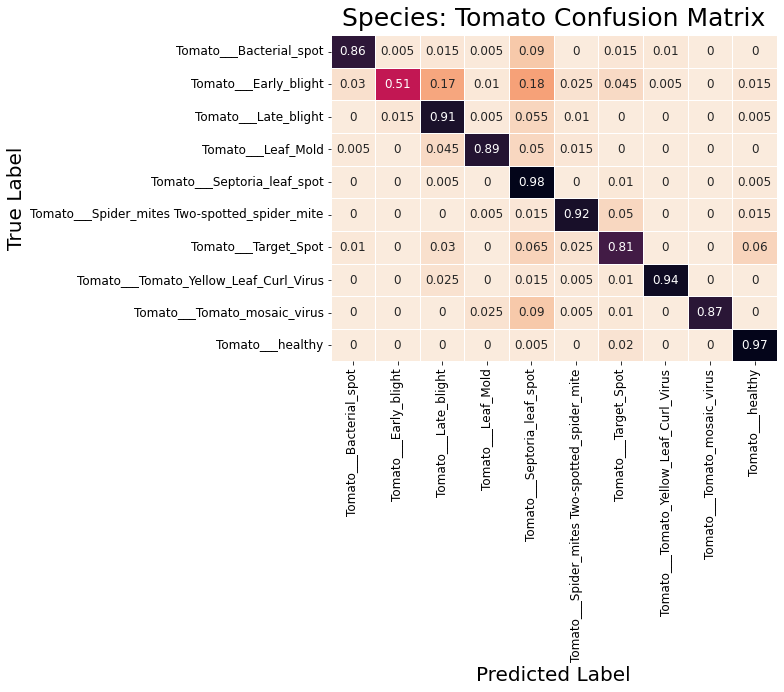

In [39]:
# define confusion matrix
conf_mat = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (8,6))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels=label_names,
            yticklabels=label_names,
            cmap="rocket_r",
            linewidths=1,
            
           )
plt.title('Species: Tomato Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

We note that the structure of this multi-class confusion matrix is such that correct classifications are on the diagonal, and for a given category, all the elements in a given row (other than the diagonal element) represent all the false negatives (FNs) for the class of that row, while all the elements in a column (other than the diagonal element) represent a false positives (FNs) for the class of that column. The true positive (TP) is the diagonal element, and the true negatives (TNs) consist of all of the items that aren't a given class and aren't incorrectly classified as that given class. From this, we can talk about precision and recall:

Precision measures what proportion of a model assigned to positive are actually members of the positive class:

$$Precision = \frac{TP}{TP+FP}$$

On the other hand, recall measures how many members of the positive class the model correctly identified out of the total positives:

$$Recall = \frac{TP}{TP+FN}$$

We can now print out the classification report, which gives us the precision and recall for each class (and the f1 score):

In [40]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test_labels, y_predict)
print(report_initial)

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       200
           1       0.96      0.51      0.67       200
           2       0.76      0.91      0.83       200
           3       0.95      0.89      0.91       200
           4       0.63      0.98      0.77       200
           5       0.92      0.92      0.92       200
           6       0.84      0.81      0.82       200
           7       0.98      0.94      0.96       200
           8       1.00      0.87      0.93       200
           9       0.91      0.97      0.94       200

    accuracy                           0.87      2000
   macro avg       0.89      0.87      0.87      2000
weighted avg       0.89      0.87      0.87      2000



From the above report, we see that lowest 3 precision scores go to: 
- (1) class 6 (which corresponds to `Tomato___Target_Spot`) at 73%, 
- (2) class 1 (which corresponds to `Tomato___Early_blight`) at 83%, and 
- (3) class 4 (which corresponds to `Tomato___Septoria_leaf_spot`) at 84%.

Correspondingly, we see that the lowest three recall scores go to: 
- (1) class 2 (which corresponds to `Tomato___Late_blight`) at 79%, 
- (2) class 4 (which corresponds to `Tomato___Septoria_leaf_spot`) at 83%, and 
- (3) class 1 (which corresponds to `Tomato___Early_blight`) at 84%.

This means that categories are most commonly incorrectly labelled as  the diseases `Target_Spot`, `Early_blight`, and `Septoria_leaf_spot` respectively (which corresponds to the precision score being low for these respective categories).

Additionally, the categories that are most commonly incorrectly labelled are `Late_blight`, `Septoria_leaf_spot`, and `Early_blight`, respectively (which corresponds to the recall score being low for these respective categories).



From a visual examination of several samples of the representative images of the classes above (from the `Data Manipulation` section), we see that `Target_spot` is very subtle, so it makes sense that it could be misused as a label frequently (other spotted things, healthy could be mislabelled as `Target_spot` easily), explaining why it's precision is so low. Also, `Septoria` and `Early_blight` look interchangable in many cases, which could explain why they also are used as labels incorrectly most frequently. 

For the recall, the `Late_blight` varies a lot (changes colors, extent, etc.), so it makes sense that it is labelled correctly most infrequently. Similarly, since `Early_blight` and `Septoria` are pretty similar, they may be mislabelled as each other often (which can be seen in the confusion matrix). We also see from the confusion matrix that `Late_blight` and `Early_blight` are mixed up frequently, which is unsuprising.

We also note that `Two_Spotted_spider_mite` is very frequently (10% of the time!) misidentified as `Target_spot`. These observations may be useful heuristics for constructing a more accurate classifier.

We can further look at a sampling (sample of 9) of misidentified photos:

Total number of incorrectly identified photos: 268 out of 2000, 13.0%.
Here is a sample of 9 incorrectly identified photos:


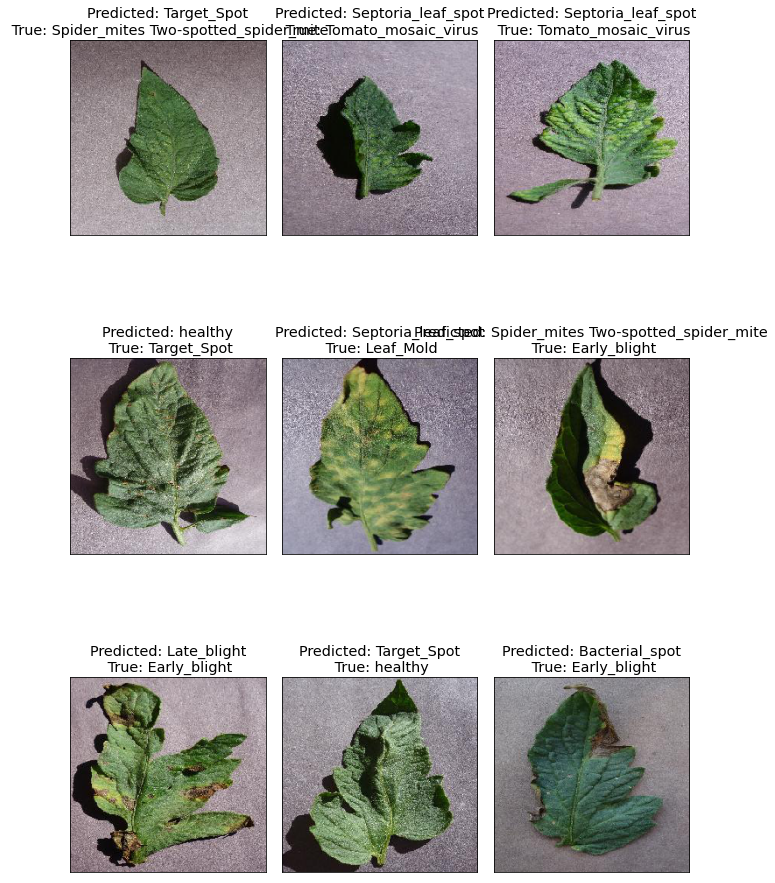

In [41]:
import math
from random import sample

# just have the disease names
disease_names = [label_names[i].split("___")[1] for i in range(len(label_names))]

# incorrect photo index
incorrect_photos = y_test_labels != y_predict


random_sample_incorrect_photos = sample(list(range(X_test[incorrect_photos].shape[0])),9)
list_random_sample = [X_test[incorrect_photos][num] for num in random_sample_incorrect_photos]
y_predict_random_sample = [y_predict[incorrect_photos][num] for num in random_sample_incorrect_photos]
y_test_labels_random_sample = [y_test_labels[incorrect_photos][num] for num in random_sample_incorrect_photos]


num_images = np.count_nonzero(incorrect_photos)
columns = 3
rows = 3

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(9, 14))

axes = axes.flatten()

for i in range(0,len(list_random_sample)):
    axes[i].imshow(list_random_sample[i], cmap='gray')

    # Get predicted label
    predicted_label = disease_names[y_predict_random_sample[i]]
    
    # Get actual label
    true_label =  disease_names[y_test_labels_random_sample[i]]
    
    # Set the title of the subplot
    axes[i].set_title(f"Predicted: {predicted_label}\n True: {true_label}")
    
    # Hide the x and y ticks
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])

# print statements:
print(f"Total number of incorrectly identified photos: {num_images} out of {len(y_predict)}, {100*round(num_images/len(y_predict),2)}%.")
print("Here is a sample of 9 incorrectly identified photos:")

fig.tight_layout()
plt.show()

Can also look at the ROC curves in order to gain more insight on the classification of our model. 

### ROC curves 

ROC curves allow us to look at the true positive rate (TPR = TP/(TP+FN)) and the false positive rate (FPR = FP/(FP+TN)) as a function of a threshold for hard classification. Usually this is used only for binary classification, but we can generalize to multi-class classification by comparing the ROC curve of a given class vs all other classes (called One versus Rest (OvR)). From this, we can see how much the classification depends on the threshold; if the classification (defined as a function of the TPR and the FPR) is largely independent of the threshold, that is a desirable outcome, as it means that the classification is mostly insensitive to where the threshold is, so we don't have to worry about it.

To do the multi-class analysis, we take definitions from the following blog for OvR:
https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

In [42]:
# import roc_auc_score
from sklearn.metrics import roc_auc_score

In [43]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [47]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [44]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

Plot the ROC curves over a range (since it is hard to get all 10 columns in a single frame):

In [45]:
def plot_ROC_OvR(start, end):   
    plt.figure(figsize = (16,8))
    bins = [i/20 for i in range(20)] + [1]
    classes = range(len(label_names))
    roc_auc_ovr = {}
    for i in range(start-1, end):
        # Gets the class
        c = classes[i]
        name = label_names[i]

        # Prepares an auxiliar dataframe to help with the plots
        df_aux = pd.DataFrame()
        df_aux['class'] = [1 if y == c else 0 for y in y_test_labels]
        df_aux['prob'] = predict_probas[:, i]
        df_aux = df_aux.reset_index(drop = True)

        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, end-(start-1), i-start+2)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(name)
        ax.legend([f"Class: {name}", "Rest"])
        ax.set_xlabel(f"P(x = {name})")

        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, end-(start-1), i+(end-(start-1))-start+2)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title("ROC Curve OvR")

        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    plt.tight_layout()

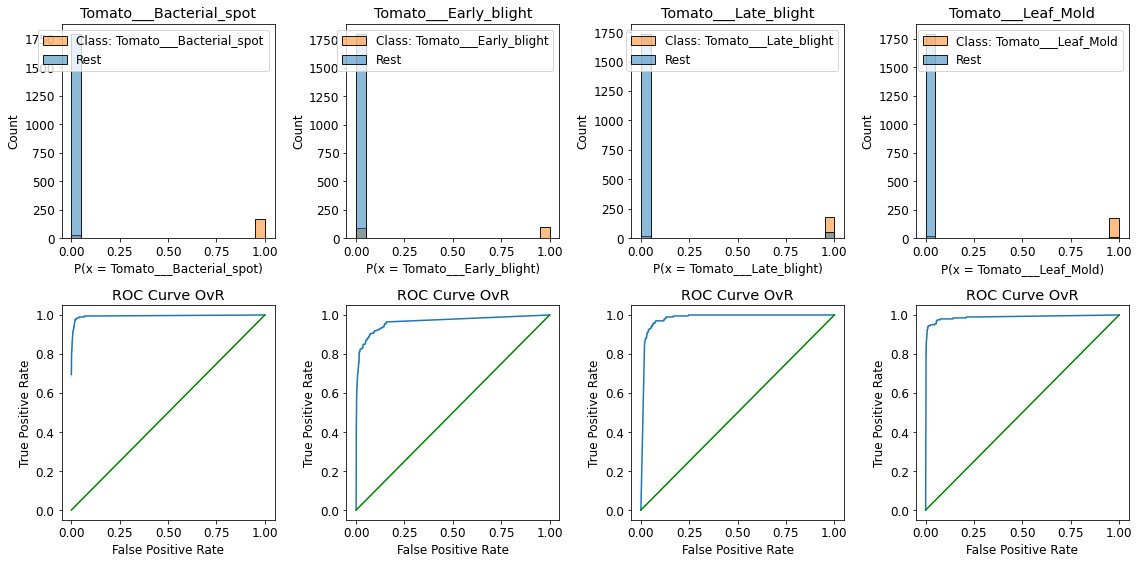

In [48]:
# plot of the first 4 ROC curves and class distributions (OvR):
plot_ROC_OvR(1,4)

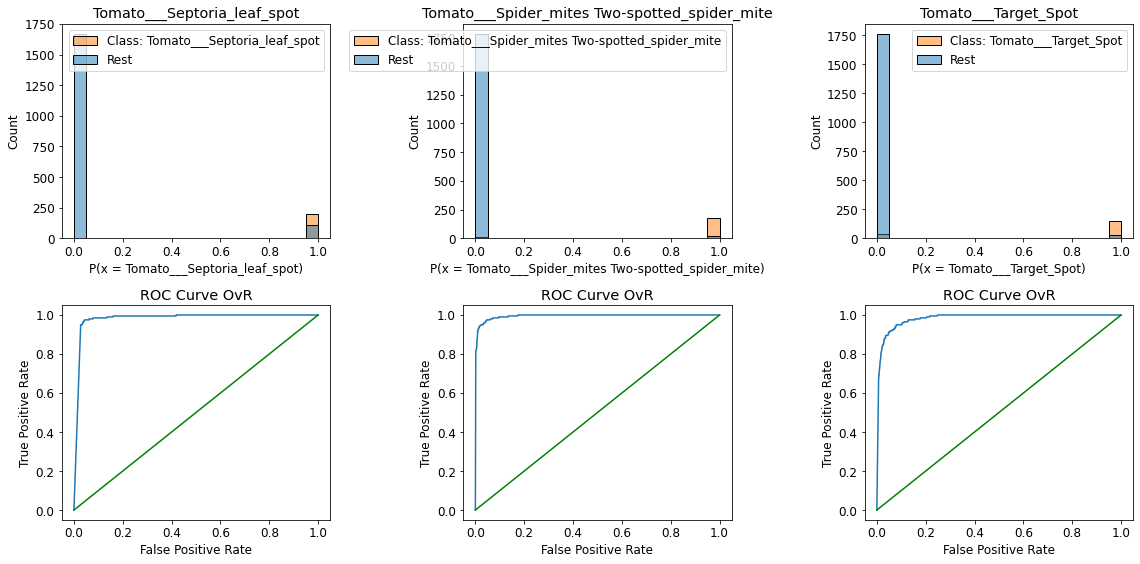

In [49]:
# plot of the ROC curves and class distributions (OvR) for classes 5-7:
plot_ROC_OvR(5,7)

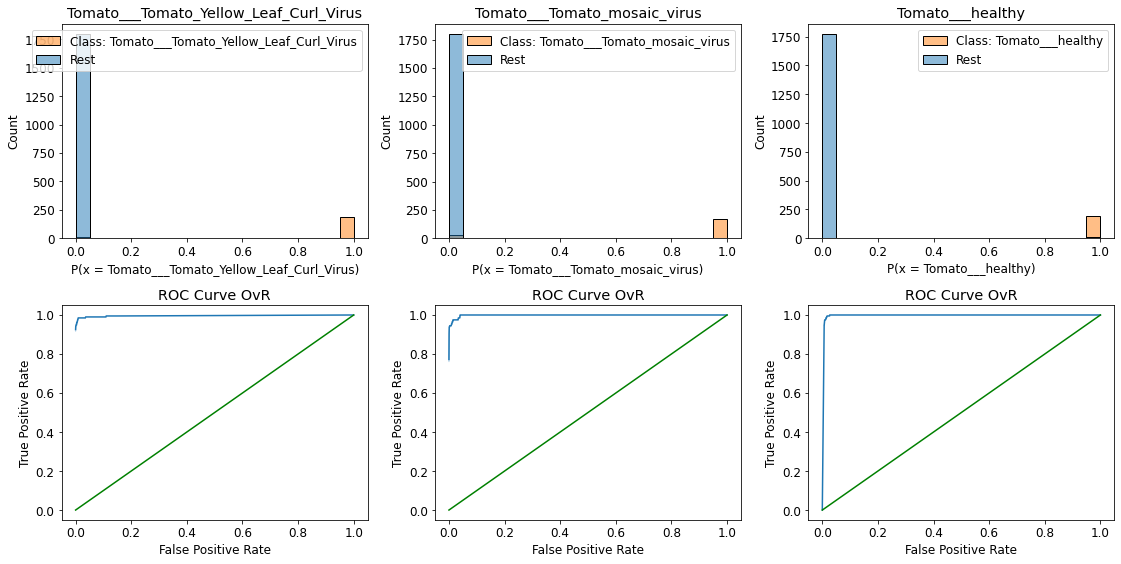

In [50]:
# plot of the ROC curves and class distributions (OvR) for classes 8-10:
plot_ROC_OvR(8,10)

We see from the above plots that the class probability distributions (of a single class vs. all others) are clearly well separated, which in turn translates to the classification being largely independent of where we set the classification threshold to be, which is also reflected in the ROC curves. In particular, a ROC curve with an area under the curve (AUC) of 1 would lead to a perfect separation of the classes, while an AUC of 0.5 would be as good as flipping a coin. Below, we print the AUC scores for the classificaiton problems of classifying a particular class:

In [51]:
# define the AUC values for each ROC curve:
classes = range(len(label_names))
roc_auc_ovr = {}
for i in range(len(label_names)):
    # Gets the class
    c = classes[i]
    name = label_names[i]

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame()
    df_aux['class'] = [1 if y == c else 0 for y in y_test_labels]
    df_aux['prob'] = predict_probas[:, i]
    df_aux = df_aux.reset_index(drop = True)
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

# print out the ROC-AUC scores:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{label_names[k]} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

Tomato___Bacterial_spot ROC AUC OvR: 0.9951
Tomato___Early_blight ROC AUC OvR: 0.9651
Tomato___Late_blight ROC AUC OvR: 0.9827
Tomato___Leaf_Mold ROC AUC OvR: 0.9886
Tomato___Septoria_leaf_spot ROC AUC OvR: 0.9816
Tomato___Spider_mites Two-spotted_spider_mite ROC AUC OvR: 0.9945
Tomato___Target_Spot ROC AUC OvR: 0.9824
Tomato___Tomato_Yellow_Leaf_Curl_Virus ROC AUC OvR: 0.9962
Tomato___Tomato_mosaic_virus ROC AUC OvR: 0.9987
Tomato___healthy ROC AUC OvR: 0.9962
average ROC AUC OvR: 0.9881


From the above, we see that all of the ROC AUC scores are very high (greater than 98% in all cases), meaning that the classification accuracy is largely independent of where a classification threshold is chosen.

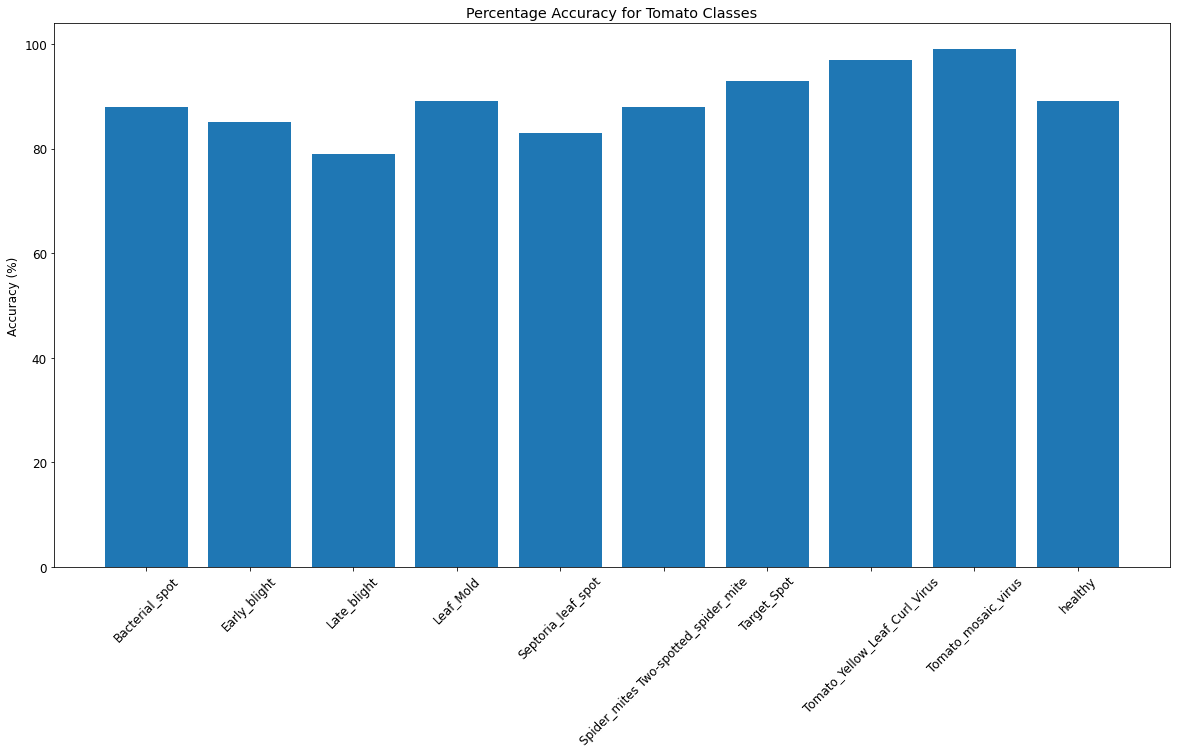

In [52]:
plt.figure(figsize = (20,10))
plt.bar(['Bacterial_spot',
                'Early_blight',
                'Late_blight',
                'Leaf_Mold',
                'Septoria_leaf_spot',
                'Spider_mites Two-spotted_spider_mite',
                'Target_Spot',
                'Tomato_Yellow_Leaf_Curl_Virus',
                'Tomato_mosaic_virus',
                'healthy'], [88,85,79,89,83,88,93,97,99,89])
plt.xticks(rotation = 45)
plt.ylabel('Accuracy (%)')
plt.title("Percentage Accuracy for Tomato Classes")
plt.show()